In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

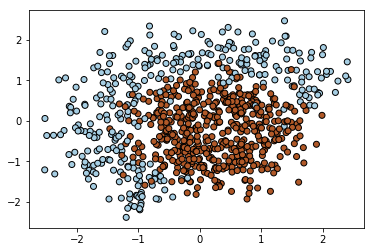

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.cast(tf.transpose(tf.gather(tf.transpose(X), [0])), tf.float32)
    X1 = tf.cast(tf.transpose(tf.gather(tf.transpose(X), [1])), tf.float32)
    X = tf.cast(X, tf.float32)
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1))], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_pl = tf.placeholder(dtype=tf.float32, shape=X.shape, name='X')
    w_pl = tf.placeholder(dtype=tf.float32, shape=w.shape, name='w')
    tmp = tf.matmul(expand(X_pl), w_pl)
    y_pred = tf.where(tmp > 0, tf.ones_like(tmp), -tf.ones_like(tmp), name='y_pred')
    
    with tf.Session() as sess:
        result = sess.run(y_pred, feed_dict={X_pl: X, w_pl: w})
    return result

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    return tf.reduce_mean(tf.maximum(0.0, 1 - tf.reshape(y, (-1, 1)) * tf.matmul(expand(X), tf.reshape(w, (-1, 1)))))
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    gr = tf.reshape(-y, (-1, 1)) * X_
    return tf.reduce_mean(tf.where(tf.maximum(0.0, 1 - tf.reshape(y, (-1, 1)) * X_ * w) > 0,
                    gr, tf.zeros_like(gr)), axis=0)
    

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [15]:
X_pl_l = tf.placeholder(tf.float32, X.shape)
y_pl_l = tf.placeholder(tf.float32, (len(y), ))

X_pl_gr = tf.placeholder(tf.float32, (batch_size, X.shape[1]))
y_pl_gr = tf.placeholder(tf.float32, (batch_size, ))

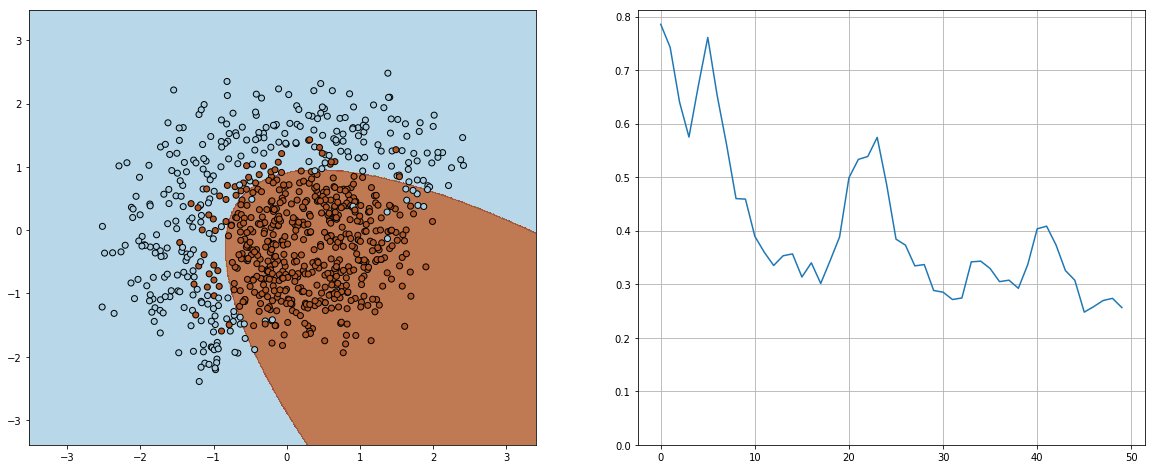

In [16]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')

alpha = 0.2 # learning rate

n_iter = 50
batch_size = 4

update_w = tf.assign_sub(w, alpha * compute_grad(X_pl_gr, y_pl_gr, w))

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})
        sess.run(update_w, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        
    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

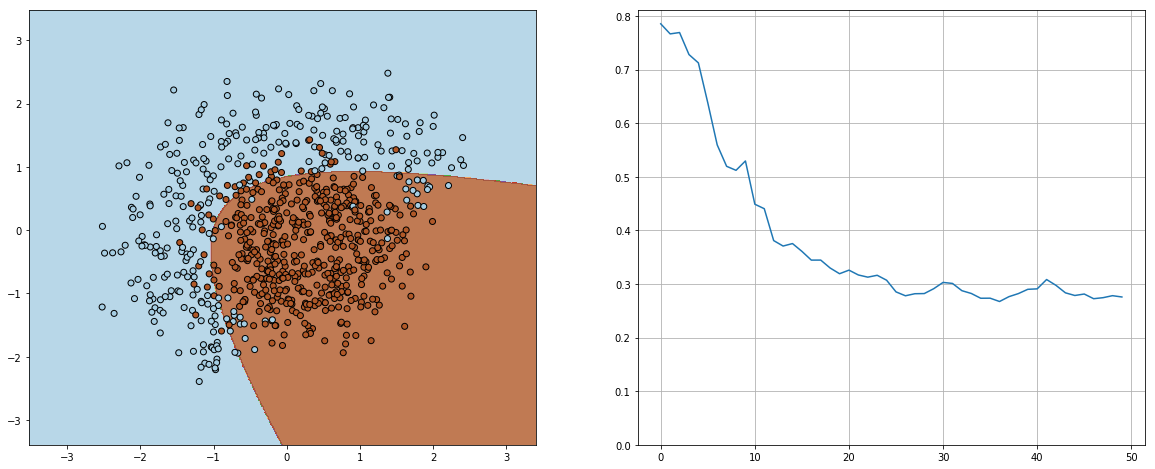

In [18]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')
v = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='v')

alpha = 0.1 # learning rate
mu    = 0.2 # momentum

update_v = tf.assign(v, mu * v  - alpha * compute_grad(X_pl_gr, y_pl_gr, w))
update_w = tf.assign_add(w, v)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})
        sess.run(update_v, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_w)

    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()

Same task but for Nesterov's accelerated gradient:

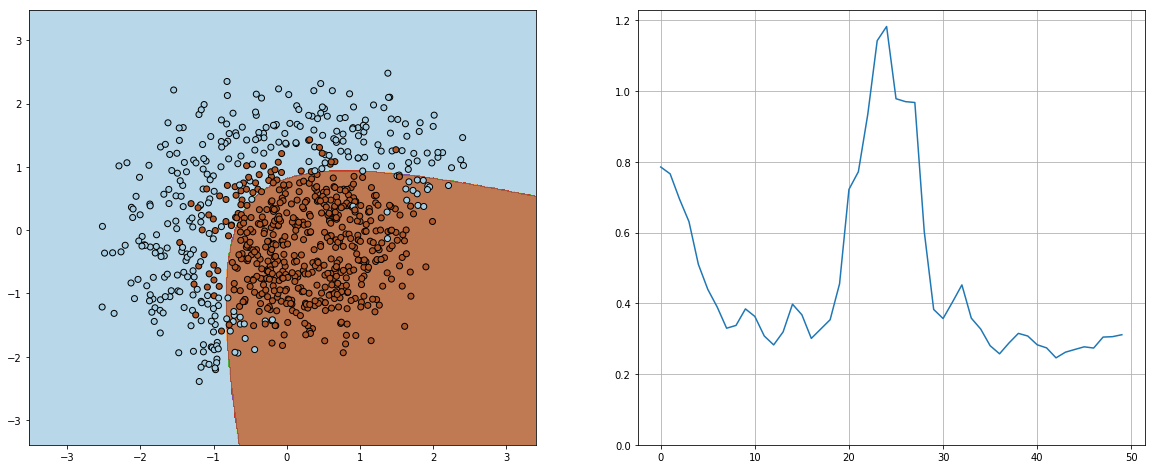

In [25]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')
v = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='v')

alpha = 0.2 # learning rate
mu    = 0.3 # momentum

update_w_imp = tf.assign_add(w, v)
update_w_grad = tf.assign_sub(w, alpha * compute_grad(X_pl_gr, y_pl_gr, w))
update_v = tf.assign(v, mu * v  - alpha * compute_grad(X_pl_gr, y_pl_gr, w))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})
        
        sess.run(update_w_imp)
        sess.run(update_w_grad, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_v, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        

    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()

Same task but for AdaGrad:

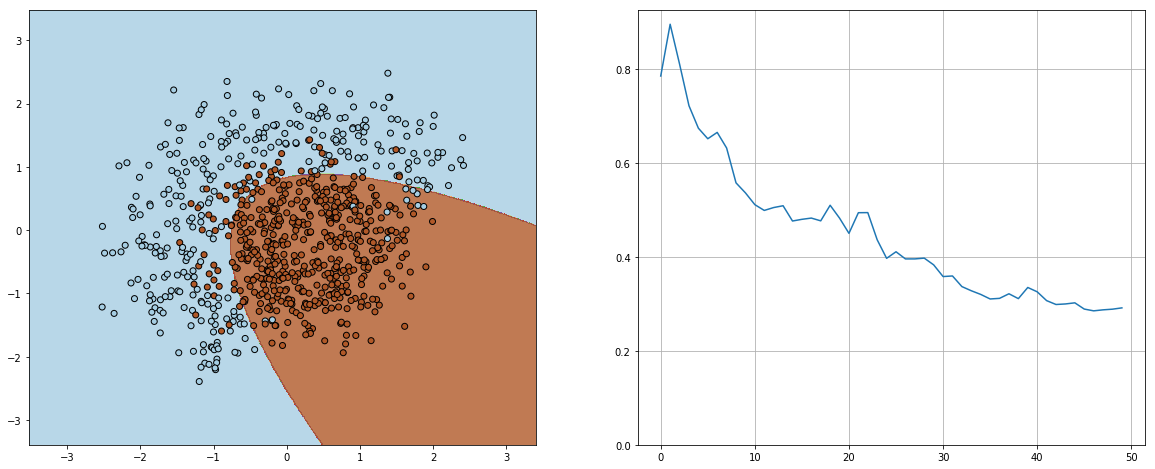

In [26]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')
c = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='c')

alpha = 0.2 # learning rate
eps = 1e-8  # A small constant for numerical stability

update_w = tf.assign_sub(w, alpha * compute_grad(X_pl_gr, y_pl_gr, w) / (tf.sqrt(c + eps)))
update_c = tf.assign_add(c, tf.pow(compute_grad(X_pl_gr, y_pl_gr, w), 2))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})
        sess.run(update_c, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_w, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})

    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()

Same task but for AdaDelta:

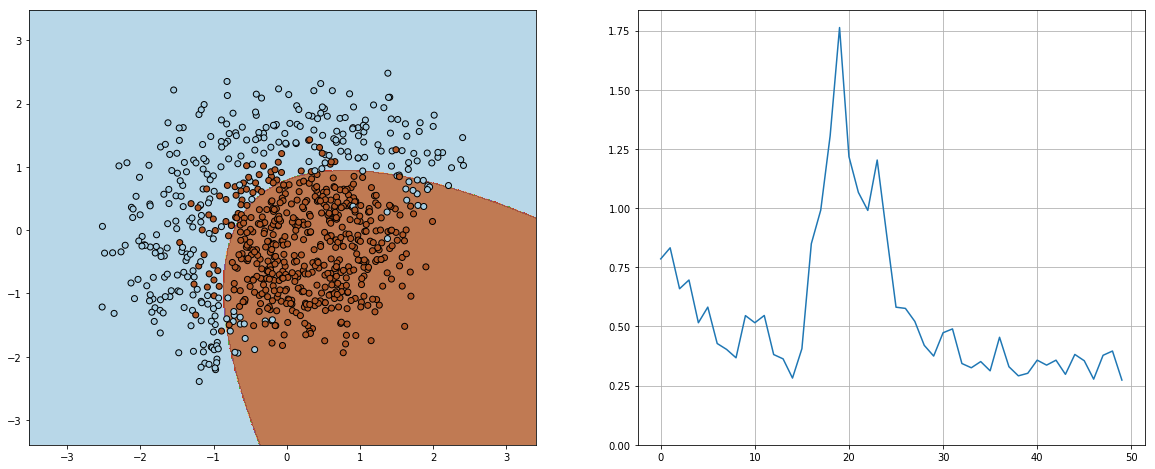

In [29]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')
c = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='c')

alpha = 0.3 # learning rate
beta = 0.3
eps = 1e-8  # A small constant for numerical stability

update_w = tf.assign_sub(w, alpha * compute_grad(X_pl_gr, y_pl_gr, w) / (tf.sqrt(c + eps)))
update_c = tf.assign(c, beta * c + (1 - beta) * tf.pow(compute_grad(X_pl_gr, y_pl_gr, w), 2))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})

        sess.run(update_c, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_w, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})

    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

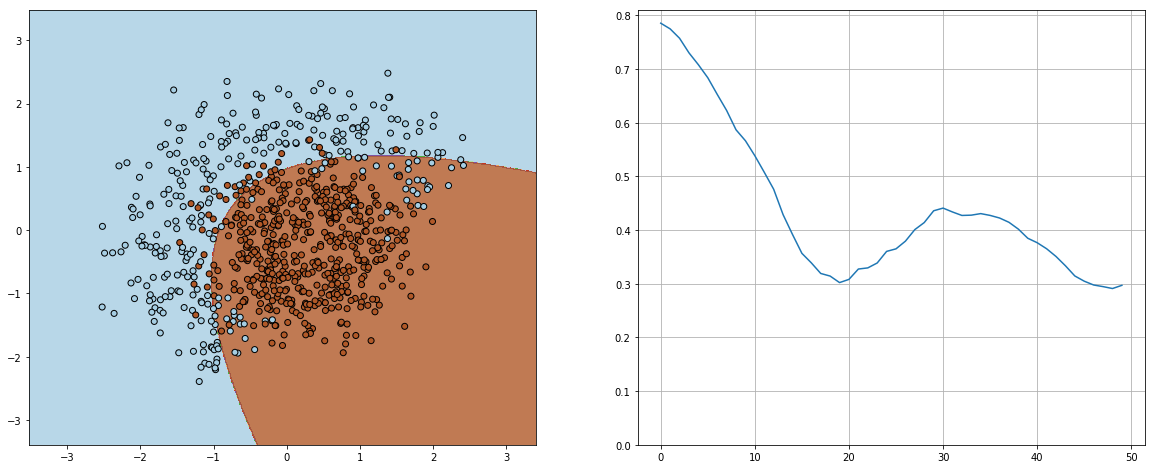

In [32]:
w = tf.Variable([1,0,0,0,0,0], dtype=tf.float32, name='weight')
c = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='c')
v = tf.Variable([0,0,0,0,0,0], dtype=tf.float32, name='v')

alpha = 0.1 # learning rate
beta = 0.2  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.9  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

update_w = tf.assign_sub(w, alpha * v / (tf.sqrt(c + eps)))
update_c = tf.assign(c, beta * c + (1 - beta) * tf.pow(compute_grad(X_pl_gr, y_pl_gr, w), 2))
update_v = tf.assign(v, mu * v + (1 - mu) * compute_grad(X_pl_gr, y_pl_gr, w))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(compute_loss(X_pl_l, y_pl_l, w), feed_dict={X_pl_l: X, y_pl_l: y})
        
        sess.run(update_v, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_c, feed_dict={X_pl_gr: X[ind], y_pl_gr: y[ind]})
        sess.run(update_w)

    visualize(X, y, (tf.reshape(w, (-1, 1))).eval(), loss, n_iter)
    plt.clf()